In [1]:

# set matplotlib to plot to pop out windows
# %matplotlib tk

from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

device = torch.device("cuda")

Random Seed:  999


# set params

In [2]:
# Root directory for dataset
dataroot = "../../data/celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1


In [3]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

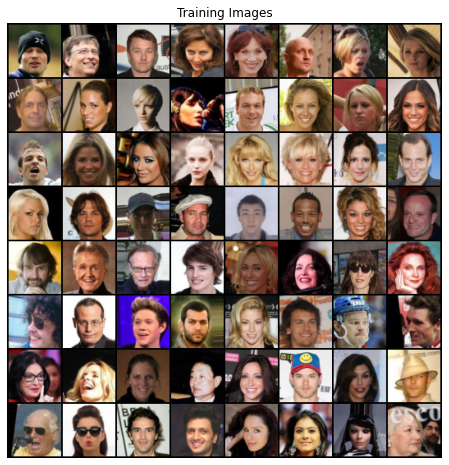

In [4]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1,2,0)))

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)


# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [7]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [8]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [9]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/1583]	Loss_D: 1.9938	Loss_G: 5.4054	D(x): 0.4964	D(G(z)): 0.6325 / 0.0067
[0/5][50/1583]	Loss_D: 0.3181	Loss_G: 10.2635	D(x): 0.9711	D(G(z)): 0.1959 / 0.0001
[0/5][100/1583]	Loss_D: 0.4592	Loss_G: 8.2655	D(x): 0.8371	D(G(z)): 0.0166 / 0.0018
[0/5][150/1583]	Loss_D: 0.2357	Loss_G: 4.3803	D(x): 0.8950	D(G(z)): 0.0848 / 0.0261
[0/5][200/1583]	Loss_D: 0.2129	Loss_G: 3.8780	D(x): 0.9272	D(G(z)): 0.0919 / 0.0315
[0/5][250/1583]	Loss_D: 0.4440	Loss_G: 3.0914	D(x): 0.7061	D(G(z)): 0.0194 / 0.0792
[0/5][300/1583]	Loss_D: 0.5314	Loss_G: 3.7146	D(x): 0.8530	D(G(z)): 0.2654 / 0.0424
[0/5][350/1583]	Loss_D: 1.2234	Loss_G: 7.0434	D(x): 0.9267	D(G(z)): 0.6024 / 0.0084
[0/5][400/1583]	Loss_D: 0.5582	Loss_G: 6.4213	D(x): 0.9420	D(G(z)): 0.3464 / 0.0043
[0/5][450/1583]	Loss_D: 0.8299	Loss_G: 3.3935	D(x): 0.5846	D(G(z)): 0.0561 / 0.0712
[0/5][500/1583]	Loss_D: 0.4003	Loss_G: 4.7847	D(x): 0.7603	D(G(z)): 0.0552 / 0.0161
[0/5][550/1583]	Loss_D: 0.3816	Loss_G: 3.8887	D(x): 

# training

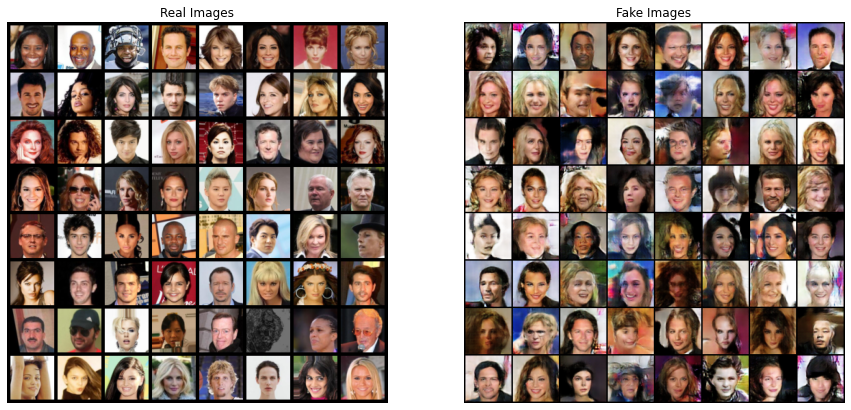

In [16]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

torch.Size([64, 3, 64, 64]) tensor([0.7595, 0.8659, 0.7781, 0.6753, 0.6213, 0.5099, 0.3431, 0.2968, 0.2218,
        0.2390])


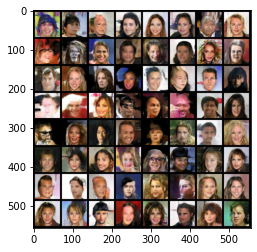

In [44]:
latents = torch.randn(64, nz, 1, 1, device=device)

fake = netG(latents).detach().cpu()
print(fake.shape, fake[0,0,0,0:10])
#plt.imshow(fake[0,:,:,:].permute(1,2,0))
plt.imshow(np.transpose(vutils.make_grid(fake[0:64,:,:,:].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

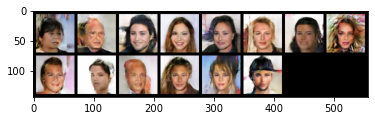

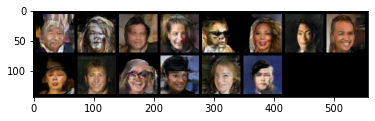

In [50]:
# separate out images into some interesting categories to explore latent space
#plt.imshow(fake[3,:,:,:].permute(1,2,0))
litebg = [1,2,3,4,5,7,13,14,48,49,50,56,57,58]
darkbg = [6,9,11,12,32,33,34,35,36,40,44,45,46,51]

plt.figure()
plt.imshow(np.transpose(vutils.make_grid(fake[litebg].to(device), padding=5, normalize=True).cpu(),(1,2,0)))
plt.figure()
plt.imshow(np.transpose(vutils.make_grid(fake[darkbg].to(device), padding=5, normalize=True).cpu(),(1,2,0)))

In [54]:
# Save the Latents
import pickle
#with open('latents.pickle', 'wb') as f:
#    pickle.dump(latents, f)

In [55]:
# Load the Latents for reuse
with open('latents.pickle', 'rb') as f:
    loaded_latents = pickle.load(f)
loaded_latents.shape

torch.Size([64, 100, 1, 1])

(28, 2)


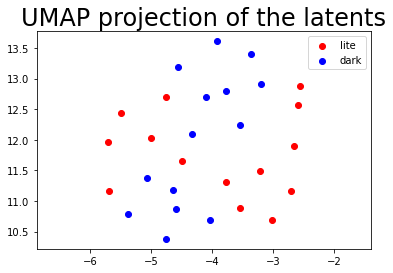

In [72]:
from sklearn.preprocessing import StandardScaler
import umap

reducer = umap.UMAP()
scaled_latents = StandardScaler().fit_transform(latents[litebg+darkbg,:,0,0].cpu())

embedding = reducer.fit_transform(scaled_latents)
print(embedding.shape)

plt.scatter(
    embedding[:len(litebg), 0],
    embedding[:len(litebg), 1],
    c='red',
    label='lite')
plt.scatter(
    embedding[len(litebg):, 0],
    embedding[len(litebg):, 1],
    c='blue',
    label='dark')
plt.legend()
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the latents', fontsize=24);

# so, the lite images and dark images are orthogonal in this space!
# I can try to do maths on them to see interesting features

In [66]:
len(litebg)+len(darkbg)

28

# play with latent math

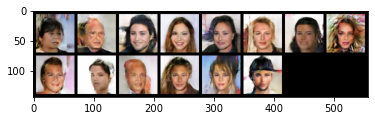

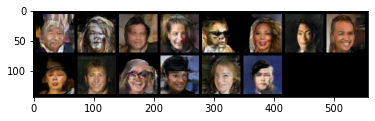

In [56]:
plt.figure()
plt.imshow(np.transpose(vutils.make_grid(fake[litebg].to(device), padding=5, normalize=True).cpu(),(1,2,0)))
plt.figure()
plt.imshow(np.transpose(vutils.make_grid(fake[darkbg].to(device), padding=5, normalize=True).cpu(),(1,2,0)))

In [166]:
litemean = torch.mean(latents[litebg,:,0,0], axis=0)
darkmean = torch.mean(latents[darkbg,:,0,0], axis=0)
bg_vec = litemean - darkmean
# this makes a vector representing features of dark (low values) to lite (high values)
# when you weight (multiply) a latent by this vector, and sum it,
# you are asking: how much of this latent represents this feature,
# so... this actually weights each column of the latent (feature) vector
# by its association to the desired feature, in this case, from dark to lite!!

# I could use this to classify an image's background,
# once I decide a decision threshold
# that is pretty sick, actually

# normalize the vector
bg_vec /= torch.sqrt(bg_vec @ bg_vec.T)
bg_vec.shape

torch.Size([100])

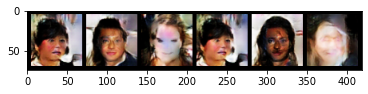

In [167]:
litebg0 = latents[litebg[0]].reshape((1,100,1,1))
fakebg0 = netG(litebg0).detach().cpu()
fakelite = netG(litemean.reshape(1,100,1,1)).detach().cpu()
fakedark = netG(darkmean.reshape(1,100,1,1)).detach().cpu()
fakebg0rem = netG((latents[litebg[0]]-bg_vec.reshape(1,100,1,1))
                  .reshape((1,100,1,1))).detach().cpu()
fakebg0prj = netG((latents[litebg[0]][:,0,0] * bg_vec)
                  .reshape(1,100,1,1)).detach().cpu()
fakebgmean = netG((0.5*litemean+0.5*darkmean)
                  .reshape(1,100,1,1)).detach().cpu()
plt.imshow(np.transpose(vutils.make_grid([fakebg0[0], fakebgmean[0], fakebg0prj[0], fakebg0rem[0], fakelite[0], fakedark[0]], padding=5, normalize=True).cpu(),(1,2,0)))

In [181]:
latents[:,:,0,0].shape, bg_vec.shape

(torch.Size([64, 100]), torch.Size([100]))

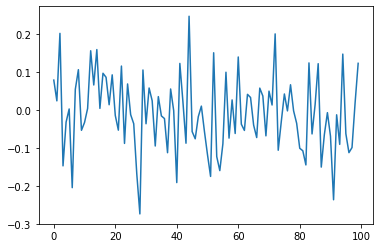

In [193]:
plt.figure()
plt.plot(bg_vec.cpu())

Text(0, 0.5, 'dark (yellow) --> lite (pink)')

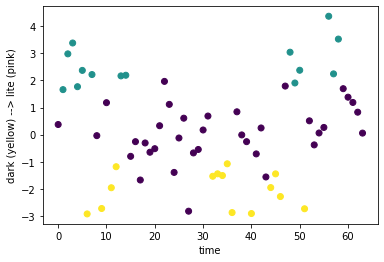

In [224]:
# the projection is just the amount each image maps onto this feature
plt.figure()
#plt.plot((latents[litebg,:,0,0] @ bg_vec.reshape(100,1)).cpu())
#plt.plot((latents[darkbg,:,0,0] @ bg_vec.reshape(100,1)).cpu())
colors = np.zeros(len(latents))
colors[litebg] = 1
colors[darkbg] = 2
#plt.plot((latents[litebg+darkbg,:,0,0] @ bg_vec.reshape(100,1)).cpu())
#plt.xlabel("latents")
#plt.ylabel("% lite = dark (low) --> lite (high) values")

scat = plt.scatter(range(0,len(latents)), (latents[:,:,0,0] @ bg_vec.reshape(100,1)).cpu(), marker='o', c=colors.tolist())
#cb = plt.colorbar(scat, spacing='proportional', ticks=colors)
plt.xlabel("time")
ylabel = plt.ylabel("dark (yellow) --> lite (pink)")

# INTERESTING!
# the projection shows a clear distinction.
# you are weighting each element by how much they contain a particular "feature"
# the direction should be light --> dark.
# that is represented by light is high, dark is low